# IBM - Machine Learning Regression Lab

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits, load_wine
from scipy.stats import boxcox
from scipy.stats.mstats import normaltest

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import sklearn; print("Scikit-Learn", sklearn.__version__)

Scikit-Learn 1.7.2


## Basic Data Info

In [2]:
data_path = "./data/CarPrice_Assignment.csv"
data = pd.read_csv(data_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [3]:
data.describe().drop('count')

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
mean,103.000000,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329756,3.255415,10.142537,104.117073,5125.121951,25.219512,30.751220,13276.710571
std,59.322565,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.270844,0.313597,3.972040,39.544167,476.985643,6.542142,6.886443,7988.852332
min,1.000000,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,52.000000,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7788.000000
50%,103.000000,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,154.000000,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16503.000000
max,205.000000,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


## Data cleaning and wrangling

In [4]:
f"There are null values: {np.any(data.isnull().sum())}, There are duplicated IDs: {sum(data.duplicated(subset = 'car_ID')) != 0}"

'There are null values: False, There are duplicated IDs: False'

Since the CarBrand column contains both the model number and the company name, we can split it to get the car brand separately. Also we need to fix some typos in the data.

In [5]:
data['brand'] = data.CarName.str.split(' ').str.get(0).str.lower()

data['brand'] = data['brand'].replace(['vw', 'vokswagen'], 'volkswagen')
data['brand'] = data['brand'].replace(['maxda'], 'mazda')
data['brand'] = data['brand'].replace(['porcshce'], 'porsche')
data['brand'] = data['brand'].replace(['toyouta'], 'toyota')

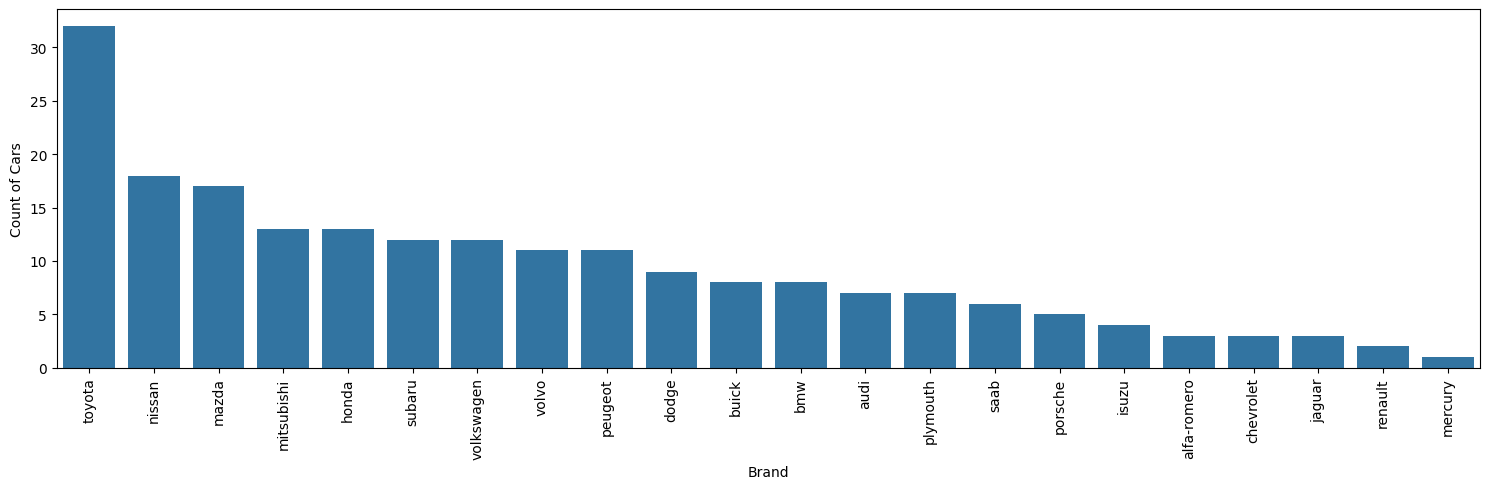

In [6]:
fig, ax = plt.subplots(figsize = (15,5))
plt1 = sns.countplot(x=data['brand'], order=data['brand'].value_counts().index)
plt1.set(xlabel = 'Brand', ylabel= 'Count of Cars')
plt.xticks(rotation=90)
plt.tight_layout()

In [7]:
data.drop(['car_ID', 'symboling', 'CarName'],axis = 1, inplace = True)

Let's engineer a few features already. We can group data by brand, and calculate the average price per brand which we can split into three bins: [Budget, Mid-Range, Luxury].

In [8]:
# Build the new feature
data_comp_avg_price = data[['brand','price']].groupby('brand', as_index = False).mean().rename(columns={'price':'brand_avg_price'})
# Add it to the original data based on the brand
data = data.merge(data_comp_avg_price, on = 'brand')
# Apply the mapping to a categorical label
data['brand_category'] = data['brand_avg_price'].apply(lambda x : "Budget" if x < 10_000 else ("Mid_Range" if x < 20_000 else "Luxury"))

In [9]:
data['brand_category'].value_counts()

brand_category
Budget       95
Mid_Range    86
Luxury       24
Name: count, dtype: int64

## EDA

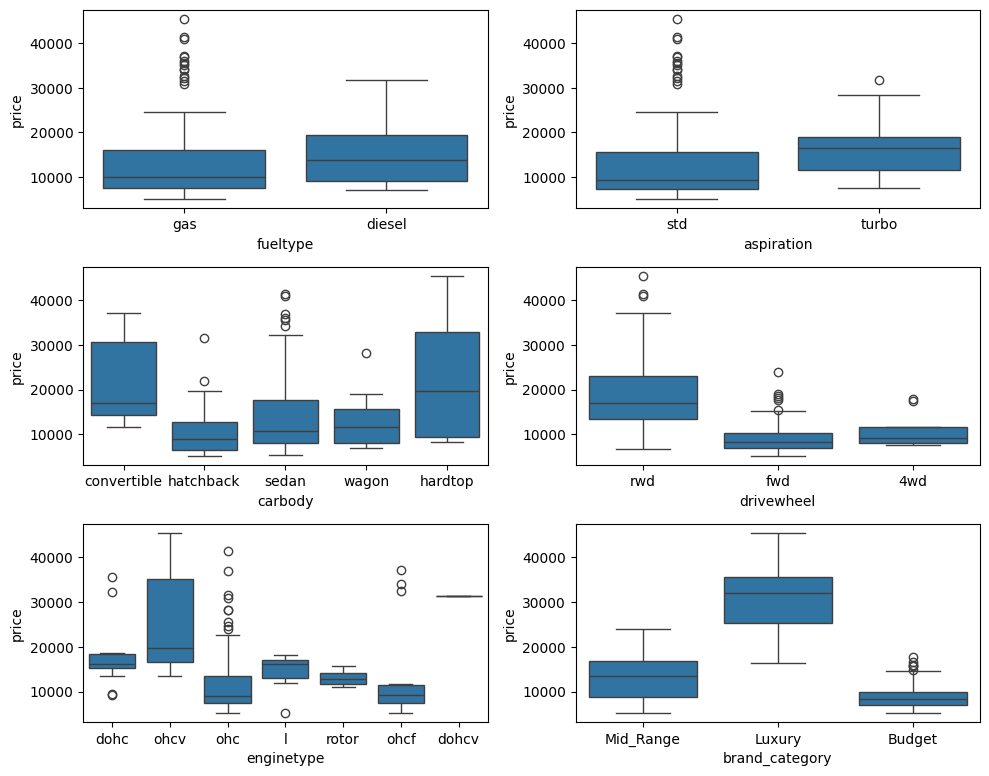

In [10]:
plt.figure(figsize=(10, 10))
plt.subplot(4,2,1)
sns.boxplot(x = 'fueltype', y = 'price', data = data)
plt.subplot(4,2,2)
sns.boxplot(x = 'aspiration', y = 'price', data = data)
plt.subplot(4,2,3)
sns.boxplot(x = 'carbody', y = 'price', data = data)
plt.subplot(4,2,4)
sns.boxplot(x = 'drivewheel', y = 'price', data = data)
plt.subplot(4,2,5)
sns.boxplot(x = 'enginetype', y = 'price', data = data)
plt.subplot(4,2,6)
sns.boxplot(x = 'brand_category', y = 'price', data = data)
plt.tight_layout()
plt.show()

price               1.000000
brand_avg_price     0.895520
enginesize          0.874145
curbweight          0.835305
horsepower          0.808139
carwidth            0.759325
carlength           0.682920
wheelbase           0.577816
boreratio           0.553173
carheight           0.119336
stroke              0.079443
compressionratio    0.067984
peakrpm            -0.085267
citympg            -0.685751
highwaympg         -0.697599
Name: price, dtype: float64

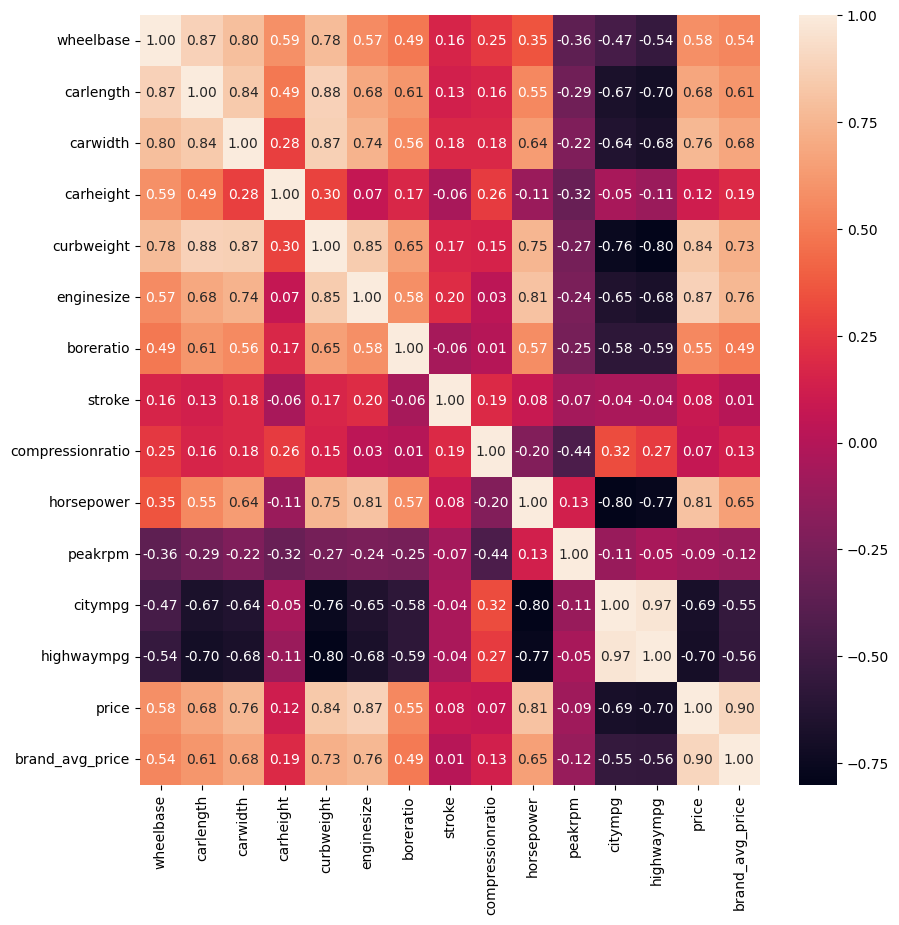

In [11]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
corr_matrix['price'].sort_values(ascending=False)

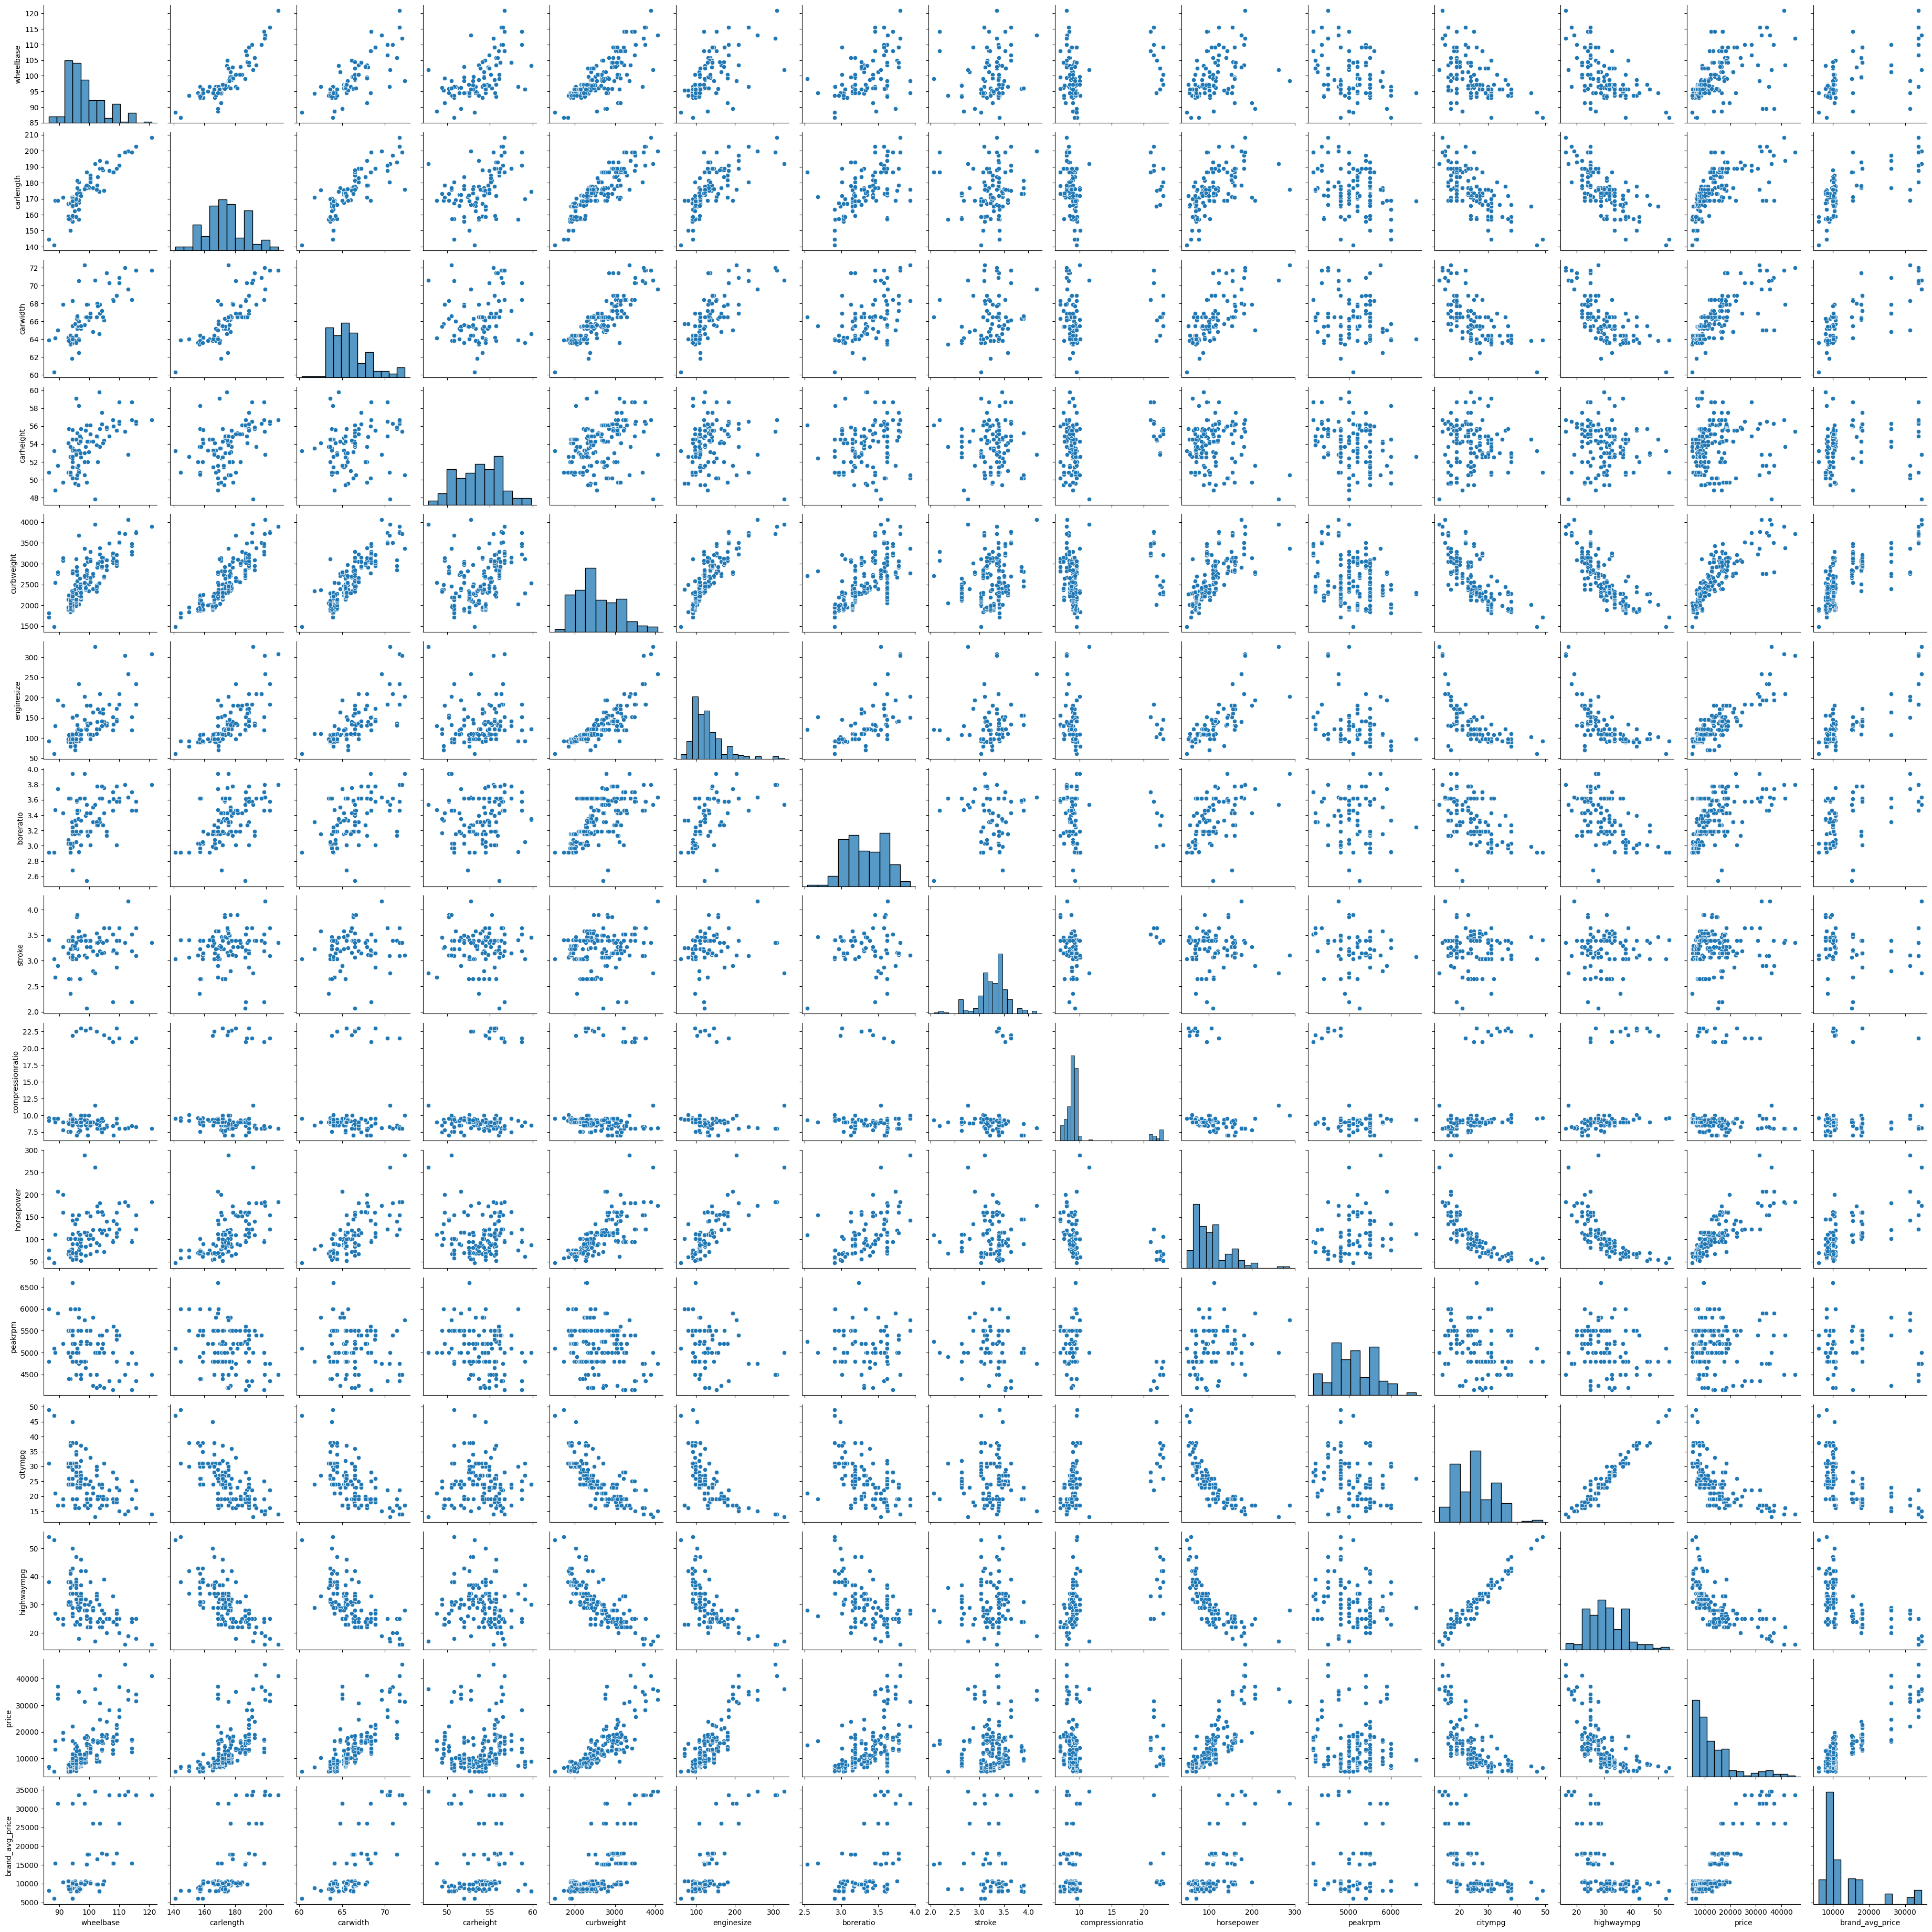

In [12]:
sns.pairplot(data)

## Testing for assumptions of linear regression

When using linear regression we assume the following:

- **Linearity** => The relationships between the features and the target is linear
- **Homoscedacity** => Equal variance of the target variable over changes in the predictor variables
- **Normality** => The dependent variable (or target, or response variable) is normally distributed.
- **Independence** => Individual observations are independent, the value of observation x_n does not depend on another observation x_m.

There are a few tests we can do to see if these assumptions are met.

### Linearity

Linearity can be visually inspected by making scatter plots and plotting regression lines. This is illustrated below for `enginesize` and `horsepower`.

<Axes: xlabel='highwaympg', ylabel='price'>

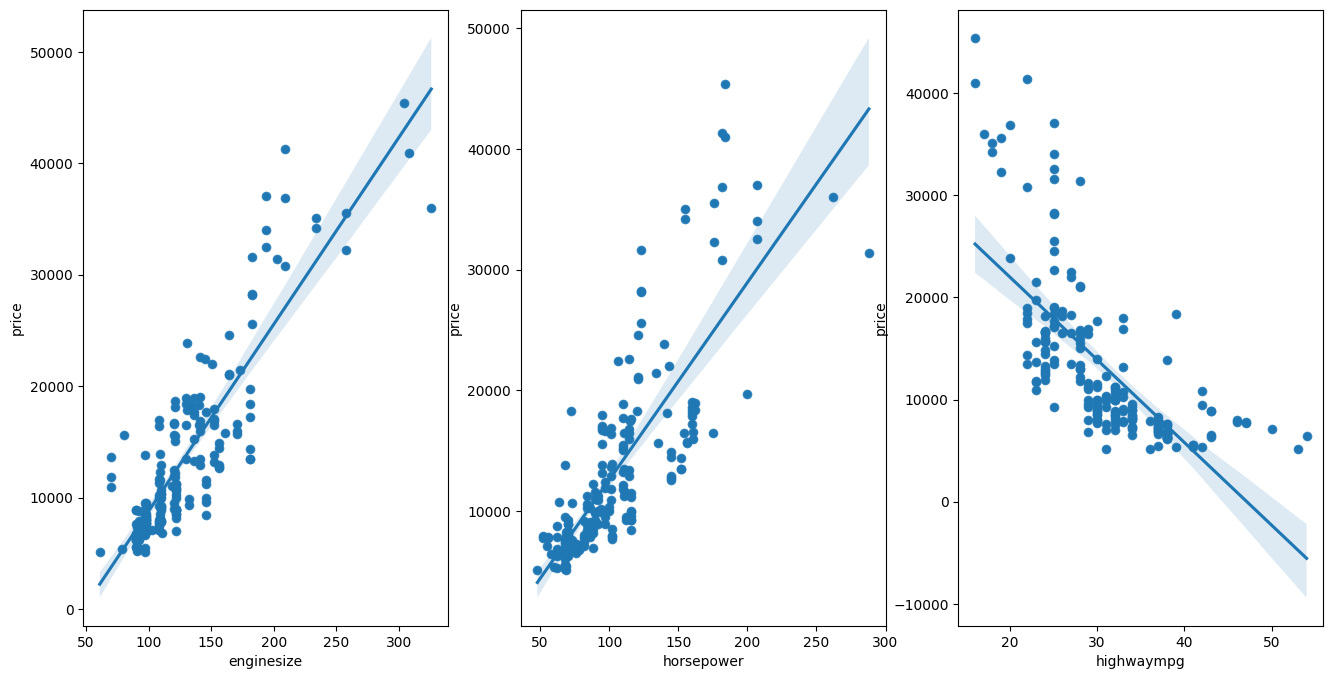

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8), sharey=False)
sns.scatterplot(x=data['enginesize'], y=data['price'], ax=ax1)
sns.regplot(x=data['enginesize'], y=data['price'], ax=ax1)

sns.scatterplot(x=data['horsepower'], y=data['price'], ax=ax2)
sns.regplot(x=data['horsepower'], y=data['price'], ax=ax2)

sns.scatterplot(x=data['highwaympg'], y=data['price'], ax=ax3)
sns.regplot(x=data['highwaympg'], y=data['price'], ax=ax3)

For the first two features, there seems to be a linear relation. But for the 3rd feature the relation looks to be higher order. It might work to add a ^2 feature here.

### Homoscedacity

This assumption states that there is a constant variance between the features and the target across all values of the features.

<Axes: xlabel='enginesize', ylabel='price'>

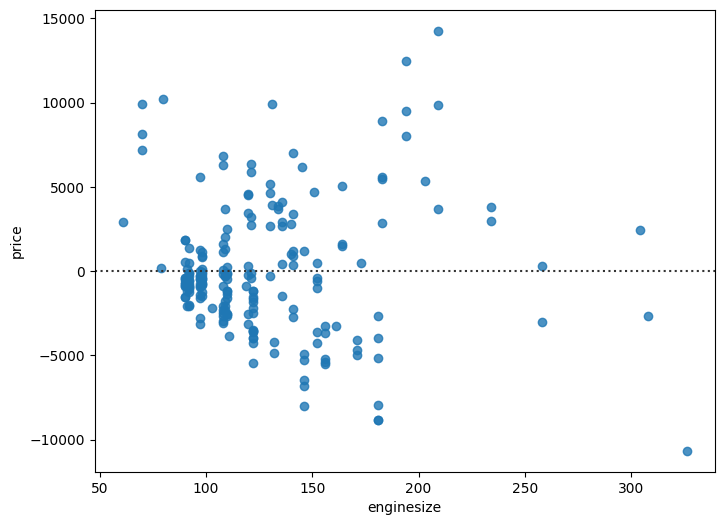

In [14]:
plt.subplots(figsize = (8,6))
sns.residplot(x=data["enginesize"], y=data["price"])

The assumption seems to be violated here since it does not look uniformly divided across any line.

### Normality

There are a few ways to check for normality, the first being visual inspection with a histogram, Q-Q plot or a box plot.

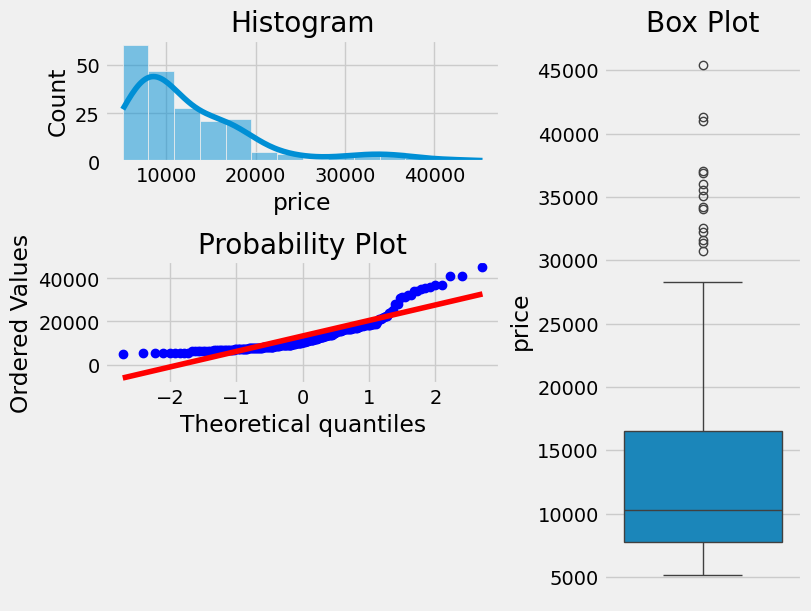

In [15]:
def plotting_3_chart(data, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(8,6))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.histplot(data.loc[:,feature], kde=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(data.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(data.loc[:,feature], orient='v', ax = ax3);
    
plotting_3_chart(data, 'price')

There are a few things we can conclude. First, the data is *not* normally distributed. It is also skewed right and there are outliers. Most values are on the lower end, with a few extreme values very far from the median. So we can conclude that this assumption is also violated.

Let's confirm our conclusion with a normal test statistic.

In [16]:
f"The result of the normal test is p={normaltest(data.price.values).pvalue:.2e}"

'The result of the normal test is p=1.58e-17'

The pvalue is extremely low, which means that the data is *not* normally distributed.

To try to fix this we can use a simple log transform to see if this improves the situation.

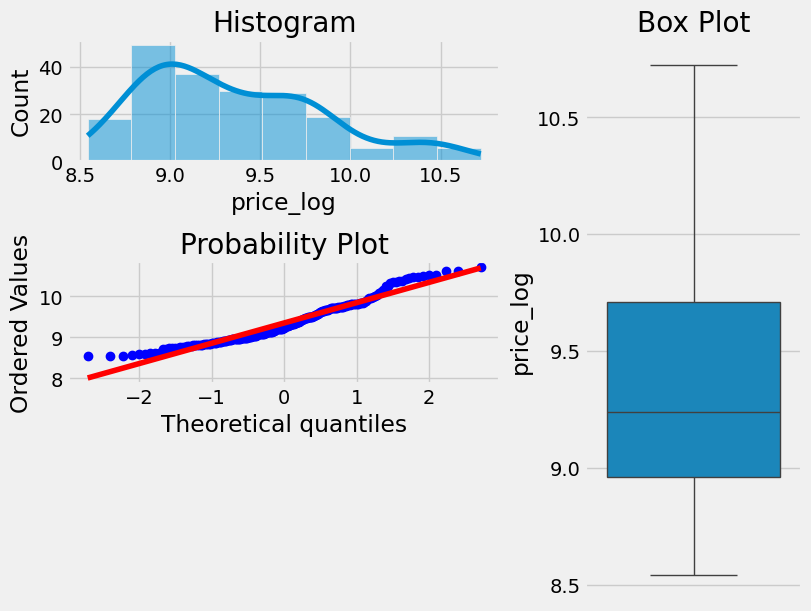

In [17]:
data['price_log'] = np.log(data['price'])
plotting_3_chart(data, 'price_log')

That looks a lot better, let's confirm with a normal test.

In [18]:
f"The result of the normal test is p={normaltest(data.price_log.values).pvalue:.2e}"

'The result of the normal test is p=8.66e-04'

Still not normally distributed, but already much better.

Now let's try the same thing using a boxcox transformation.

'The result of the normal test is p=2.33e-04'

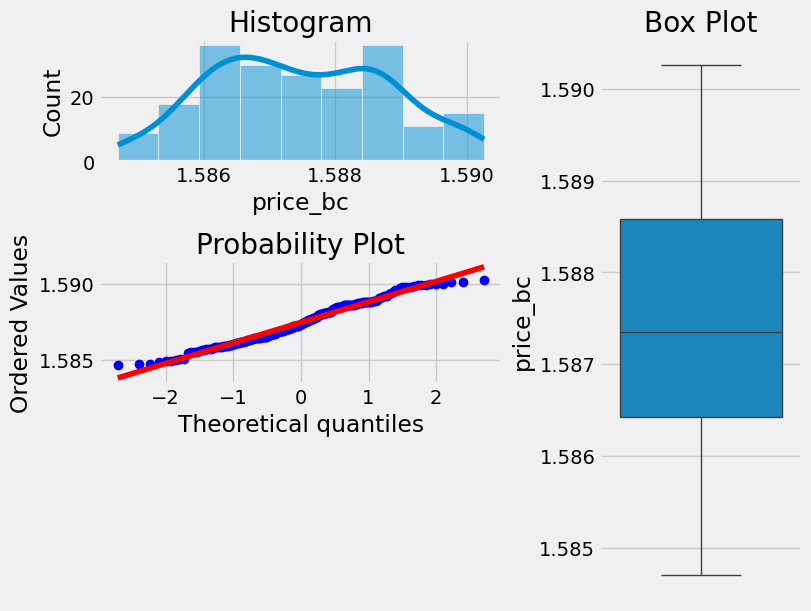

In [19]:
data['price_bc'], lam = boxcox(data['price'])
plotting_3_chart(data, 'price_bc')
f"The result of the normal test is p={normaltest(data.price_bc.values).pvalue:.2e}"

Still not normally distributed, but for now the best we can get.

### Multicollinearity

In this case, different features will depend on each other. This makes it very hard for the model to make a good fit since either of those variables can predict the same changes in the target variable. The result of each effect of predictor variables will depend on the other variables that are included. The effect of small changes in the input data is also affected. Matrix calculations can break down, leading to inaccuracies in computer calculations and it becomes very hard to interpret coefficients for each variable.

Taking a look at a heatmap of correlations can give a lot of insight into which correlations are present in the data.

<Axes: >

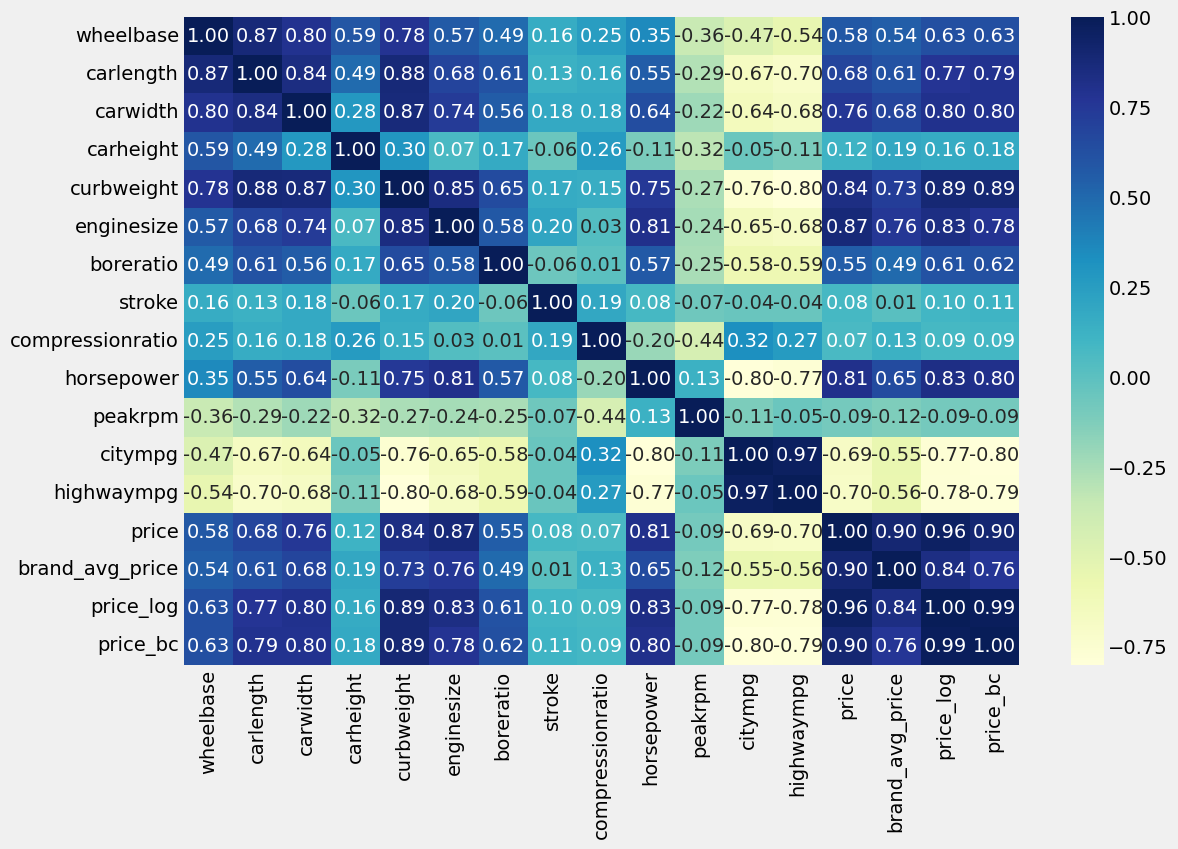

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(numeric_only=True), annot=True, fmt='.2f', cmap="YlGnBu")

There are a few strong correlations (like between car length and height, which makes sense). For now, we'll keep the features as they are, at a later stage more sophisticated models can take care of this.

## Linear Regression Model

We take the following columns as numeric features: 

`['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'carlength', 'carwidth', 'citympg', 'highwaympg']`

And the following as categorical features:

`['enginetype', 'fueltype', 'carbody', 'aspiration', 'cylindernumber', 'drivewheel', 'brand_category']`

With `price` being the target variable.

In [21]:
cols_numeric = ['wheelbase', 'curbweight', 'enginesize', 'boreratio', 'horsepower', 'carlength', 'carwidth', 'citympg', 'highwaympg']
cols_categorical = ['enginetype', 'fueltype', 'carbody', 'aspiration', 'cylindernumber', 'drivewheel', 'brand_category']
col_target = ['price_bc']

selected = data[cols_numeric + cols_categorical + col_target]
selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wheelbase       205 non-null    float64
 1   curbweight      205 non-null    int64  
 2   enginesize      205 non-null    int64  
 3   boreratio       205 non-null    float64
 4   horsepower      205 non-null    int64  
 5   carlength       205 non-null    float64
 6   carwidth        205 non-null    float64
 7   citympg         205 non-null    int64  
 8   highwaympg      205 non-null    int64  
 9   enginetype      205 non-null    object 
 10  fueltype        205 non-null    object 
 11  carbody         205 non-null    object 
 12  aspiration      205 non-null    object 
 13  cylindernumber  205 non-null    object 
 14  drivewheel      205 non-null    object 
 15  brand_category  205 non-null    object 
 16  price_bc        205 non-null    float64
dtypes: float64(5), int64(5), object(7)


In [22]:
X = selected.drop('price_bc', axis=1)
y = selected['price_bc'].copy()

### OneHotEncoder

Now we can transform the categorical features as One-Hot encoded variables. This is done mainly because the linear regression model does not know how to handle categorical features. So we add switches for each category that can either be 1 or 0. Then a coefficient is learned for each of those switches. This way the categories can still be encoded in our model.

For this we will use sklearn's `OneHotEncoder`. With most data transformations the workflow is:

1. Split data into test and train
2. Fit and Transform the train data
3. Transform the test data using the fit performed on the train data

However, with One-Hot encoding this is not necessary since the transformation is deterministic, this means it is not dependent on the contents of the data, as opposed to many other data transformations. The only thing that matters is the presence or absence of categories, which would become a problem in the above scheme when categories are underrepresented and not present in the train split.

In [23]:
for column in  cols_categorical:
    print("column name:", column)
    print("value_count:")
    print( X[column].value_counts())

column name: enginetype
value_count:
enginetype
ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: count, dtype: int64
column name: fueltype
value_count:
fueltype
gas       185
diesel     20
Name: count, dtype: int64
column name: carbody
value_count:
carbody
sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: count, dtype: int64
column name: aspiration
value_count:
aspiration
std      168
turbo     37
Name: count, dtype: int64
column name: cylindernumber
value_count:
cylindernumber
four      159
six        24
five       11
eight       5
two         4
twelve      1
three       1
Name: count, dtype: int64
column name: drivewheel
value_count:
drivewheel
fwd    120
rwd     76
4wd      9
Name: count, dtype: int64
column name: brand_category
value_count:
brand_category
Budget       95
Mid_Range    86
Luxury       24
Name: count, dtype: int64


As we can see, some categories are severely underrepresented.

We can use the `ColumnTransformer` helper class from sklearn to easily apply transformations to columns.

*   name: name of the operation that can be used later
*   `transformer`: estimator must support fit and transform, in this case we will use `OneHotEncoder()`
*   `‘drop’`: to  drop the columns
*   `‘passthrough’`: to pass them through untransformed data
*   `remainder`: specifies the columns that are not transformed are being set to `passthrough`. They are  combined in the output, and the non-specified columns are dropped.

In [24]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), cols_categorical) ],remainder="passthrough")
X = one_hot.fit_transform(X)
col_names = one_hot.get_feature_names_out()
col_names = [name[name.find("_")+1:] for name in  [name[name.find("__")+2:] for name in col_names]]
X = pd.DataFrame(data=X,columns=col_names)

In [26]:
X.shape

(205, 38)

Now, let's apply the following to set everything up for training:

- Train-test split
- Standardisation

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
ss = StandardScaler()
X_train = ss.fit_transform(X_train)

Now we can finally train and make predictions.

In [29]:
lr = LinearRegression()
lr.fit(X_train, y_train)

X_test = ss.transform(X_test)

car_price_predictions = lr.predict(X_test)
car_price_predictions = inv_boxcox(car_price_predictions, lam)

And perform some analysis on the model performance.

In [34]:
mse = mean_squared_error(y_test, car_price_predictions)
f"{mse=:.2f}"

'mse=29904994703.53'

In [32]:
f"R^2 = {lr.score(X_test, y_test):.2f}"

'R^2 = 0.81'

In [35]:
from sklearn.metrics import r2_score 
r2_score(y_test,car_price_predictions)

-1.57757099310003e+16

## Sklearn Pipelines

Pipelines are sklearn constructs that allow the creation of sequences of operations. For example, we can add scaling and fitting a regression model to the pipeline and in that way the data is always scaled before hitting the regression model.

In [37]:
steps=[('scaler', StandardScaler()), ('lm',  LinearRegression())]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
car_price_predictions = pipe.predict(X_test)
mse = mean_squared_error(y_test, car_price_predictions)
rmse = np.sqrt(mse)
r2_score(car_price_predictions, y_test)

0.8261380020933107

In [38]:
X = selected[cols_categorical+cols_numeric]
one_hot = ColumnTransformer(transformers=[("one_hot", OneHotEncoder(), cols_categorical) ],remainder="passthrough")
steps=[('one_hot',one_hot), ('scaler', StandardScaler()), ('lm',  LinearRegression())]

pipe = Pipeline(steps=steps)
pipe.fit(X,y)
car_price_predictions=pipe.predict(X)
r2_score(car_price_predictions, y)

0.9087825652731842